In [1]:
#pip install pymc3

In [2]:
import numpy as np
import pandas as pd 
import pymc3
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import theano.tensor as tt



In [3]:
# set background to dark

plt.style.use("dark_background")

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '#cccccc'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#404040'  # dark grey
    
plt.rcParams['axes.axisbelow'] = True

colors = sns.color_palette("YlGn", 5)
sns.set_palette(colors)

In [4]:
np.random.seed(42)

In [5]:

# choose more accurate lambdas that aren't so close to 0 
# then bar charts


In [6]:
n = 1000
group_list = ['A', 'B', 'C', 'D', 'E']   
beta_list = [4.9, 6.0, 3.5, 4.0, 5.1]                    # beta = 1/lambda
p_list = [0.58, 0.80, 0.45, 0.56, 0.62]

# A - current playlist
# B - longer to skip, less skips
# C - quicker to skip, more skips
# D - quicker to skip, same skips
# E - same to skip, same skips


full_df = pd.DataFrame()

for g in range(len(group_list)):
    
    curr_group = group_list.pop(0)
    curr_beta = beta_list.pop(0)
    curr_p = p_list.pop(0)
    
    skip_times = np.round(np.random.exponential(scale = curr_beta, size = n), 6)
    skipped = np.random.binomial(size = n, n = 1, p = curr_p)
    
    df = pd.DataFrame(skip_times, columns = ['skip_times'])
    
    df['skipped'] = skipped
    df['skip_times'] = skip_times
    df['skip_times'] = np.where(df['skipped'] == 0, np.nan, df['skip_times'])
    
    df['test_group'] = curr_group
    
    full_df = full_df.append(df)

full_df = full_df.reset_index(drop=True).reset_index().rename(columns = {'index':'user_id'})

In [7]:
full_df

,user_id,skip_times,skipped,test_group
0,0,2.299414,1,A
1,1,14.749595,1,A
2,2,NaN,0,A
3,3,NaN,0,A
4,4,NaN,0,A
...,...,...,...,...
4995,4995,NaN,0,E
4996,4996,NaN,0,E
4997,4997,NaN,0,E
4998,4998,0.582443,1,E


In [8]:
full_df['test_group'].value_counts()

A    1000
B    1000
E    1000
C    1000
D    1000
Name: test_group, dtype: int64

In [9]:

did_skip = full_df[full_df['skipped'] == 1]['skipped'].value_counts().values[0]
did_not_skip = full_df[full_df['skipped'] == 0]['skipped'].value_counts().values[0]

percent_skipped = did_skip / len(full_df)

print(f"Out of all groups {round(percent_skipped*100,2)}% skipped the song.")

Out of all groups 60.58% skipped the song.


In [10]:
skip_df = full_df.dropna()

In [11]:
# alpha, beta, mean, variance, and std of control group

mean_of_A = skip_df[skip_df['test_group']=='A']['skip_times'].mean()
std_of_A = skip_df[skip_df['test_group']=='A']['skip_times'].std()
var_of_A = skip_df[skip_df['test_group']=='A']['skip_times'].var()

alpha_of_A = mean_of_A**2 / var_of_A
beta_of_A = mean_of_A / var_of_A

print("STATISTICS FOR CONTROL GROUP A\n")
print(f"Mean:   {round(mean_of_A, 4)}")
print(f"Std:    {round(std_of_A, 4)}")
print(f"Var:    {round(var_of_A, 4)}")
print(f"Alpha:  {round(alpha_of_A, 4)}")
print(f"Beta:   {round(beta_of_A, 4)}")

STATISTICS FOR CONTROL GROUP A

Mean:   4.5091
Std:    4.449
Var:    19.7939
Alpha:  1.0272
Beta:   0.2278


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam_E, lam_D, lam_C, lam_B, lam_A, sigma, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 33 seconds.


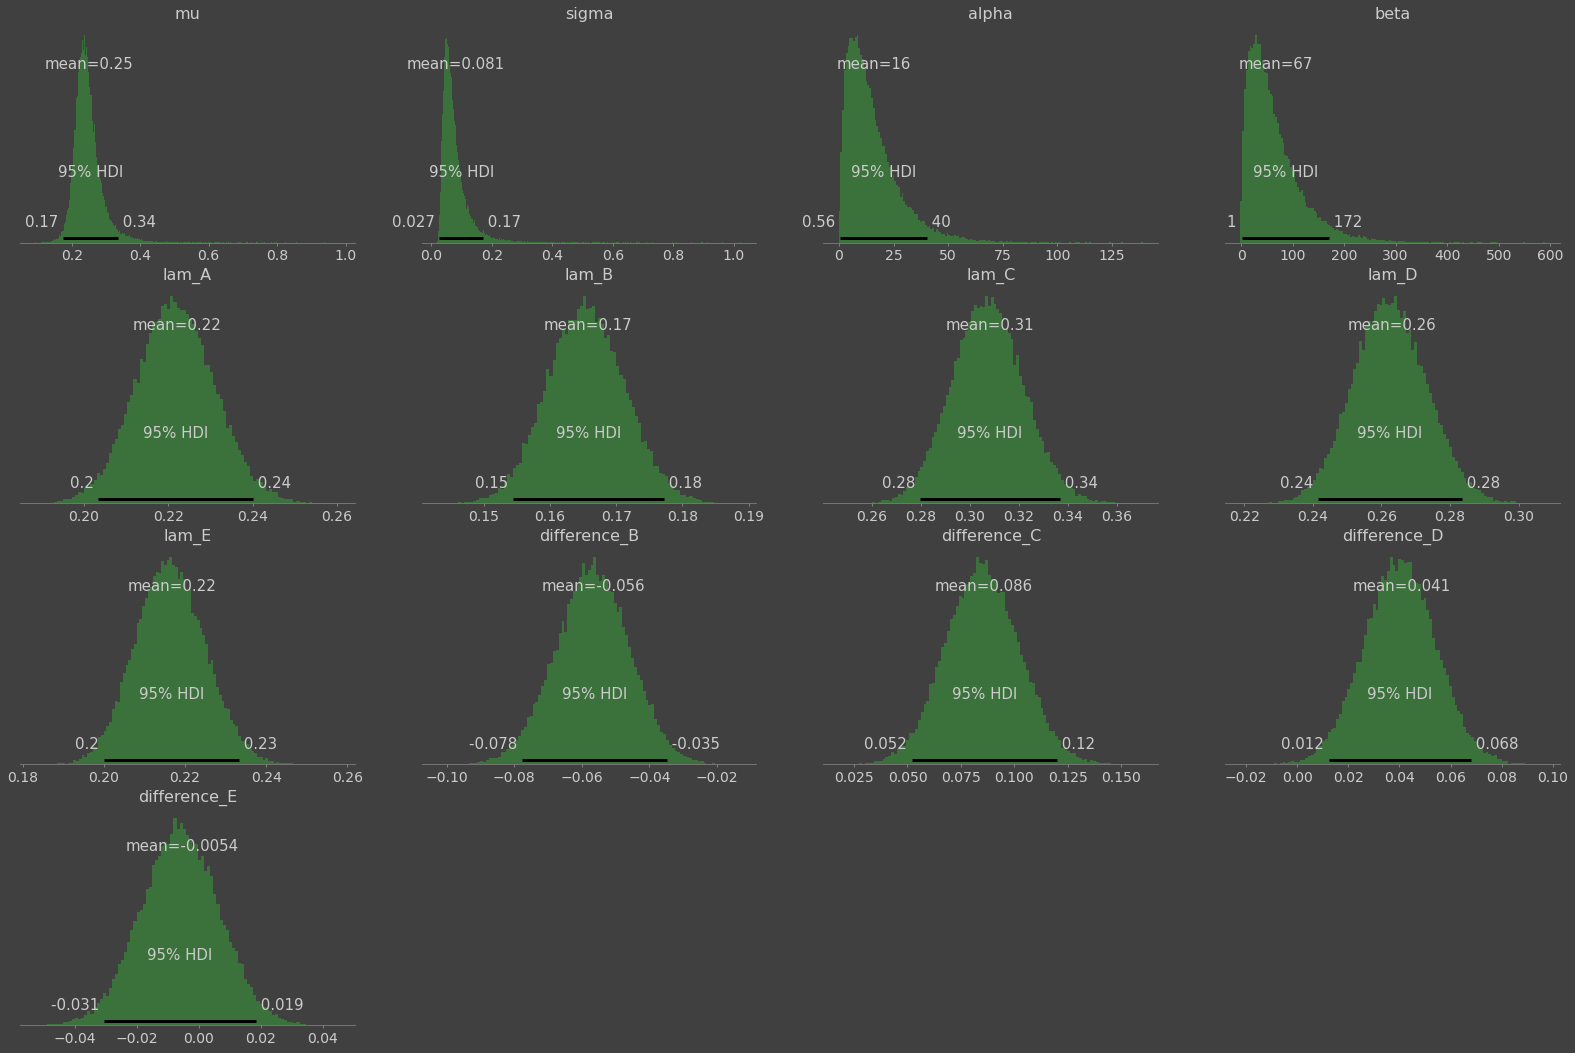

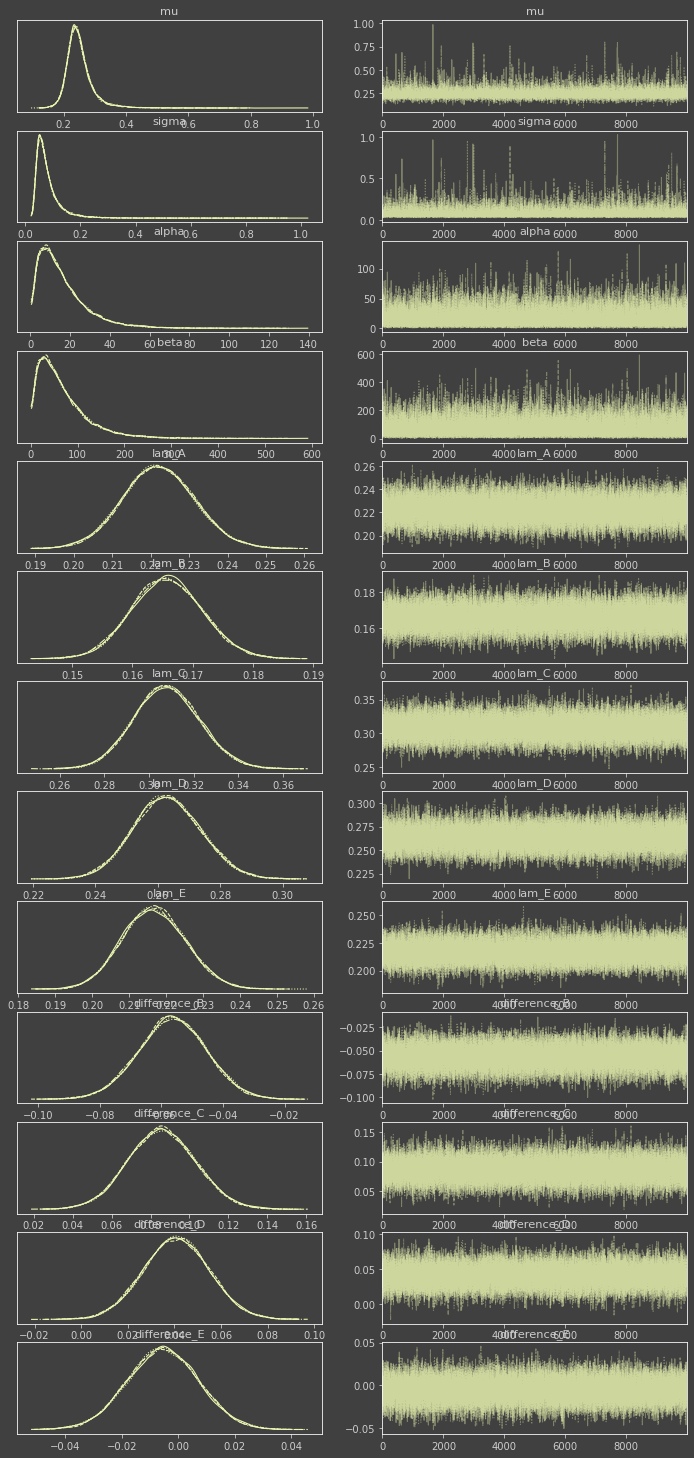

In [12]:

with pymc3.Model() as model:
    
    # define hyperpriors
    mu = pymc3.Gamma('mu', alpha=alpha_of_A, beta=beta_of_A)
    sigma = pymc3.Exponential('sigma', std_of_A)
    alpha =  pymc3.Deterministic('alpha', mu**2 / sigma**2)
    beta = pymc3.Deterministic('beta', mu / sigma**2)

    # define priors
    lam_A = pymc3.Gamma('lam_A', alpha=alpha, beta=beta)
    lam_B = pymc3.Gamma('lam_B', alpha=alpha, beta=beta)
    lam_C = pymc3.Gamma('lam_C', alpha=alpha, beta=beta)
    lam_D = pymc3.Gamma('lam_D', alpha=alpha, beta=beta)
    lam_E = pymc3.Gamma('lam_E', alpha=alpha, beta=beta)
    
    # define likelihood
    obs_A = pymc3.Exponential('obs_A', lam=lam_A, observed=skip_df[skip_df['test_group'] == 'A']['skip_times'])
    obs_B = pymc3.Exponential('obs_B', lam=lam_B, observed=skip_df[skip_df['test_group'] == 'B']['skip_times'])
    obs_C = pymc3.Exponential('obs_C', lam=lam_C, observed=skip_df[skip_df['test_group'] == 'C']['skip_times'])
    obs_D = pymc3.Exponential('obs_D', lam=lam_D, observed=skip_df[skip_df['test_group'] == 'D']['skip_times'])
    obs_E = pymc3.Exponential('obs_E', lam=lam_E, observed=skip_df[skip_df['test_group'] == 'E']['skip_times'])
    
    # define metrics
    pymc3.Deterministic('difference_B', lam_B - lam_A)
    pymc3.Deterministic('difference_C', lam_C - lam_A)
    pymc3.Deterministic('difference_D', lam_D - lam_A)
    pymc3.Deterministic('difference_E', lam_E - lam_A)
    
    # sample distributions
    trace = pymc3.sample(draws=10000,  start = pymc3.find_MAP(), step=pymc3.NUTS(target_accept=0.95), progressbar=True, return_inferencedata=False)
    
    az.plot_posterior(trace, kind="hist", hdi_prob = 0.95, color = 'limegreen')
    az.plot_trace(trace)


In [13]:
print(trace.varnames)

['mu_log__', 'sigma_log__', 'lam_A_log__', 'lam_B_log__', 'lam_C_log__', 'lam_D_log__', 'lam_E_log__', 'mu', 'sigma', 'alpha', 'beta', 'lam_A', 'lam_B', 'lam_C', 'lam_D', 'lam_E', 'difference_B', 'difference_C', 'difference_D', 'difference_E']


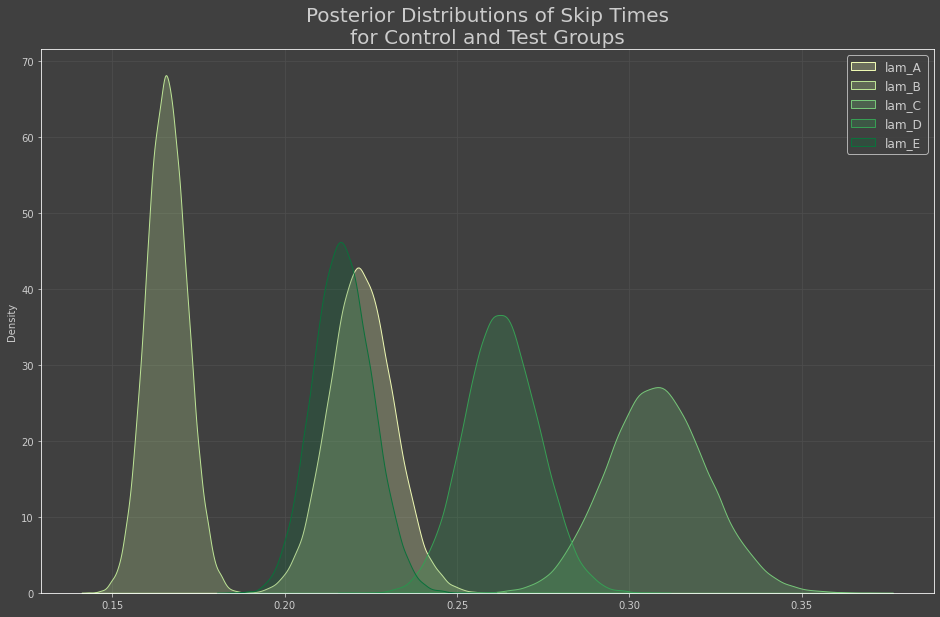

In [14]:
plt.figure(figsize=(16,10))

posteriors = []
posterior_vars = ['lam_A', 'lam_B', 'lam_C', 'lam_D', 'lam_E']

for p in posterior_vars:
    posteriors.append(trace.get_values(p, burn=100))

for posterior in posteriors:
    sns.kdeplot(posterior ,shade=True, palette=colors, legend = True)
    
plt.legend(loc="upper right", labels = posterior_vars, fontsize=12)
plt.title("Posterior Distributions of Skip Times\nfor Control and Test Groups", fontsize=20)
plt.grid(color='#4d4d4d')

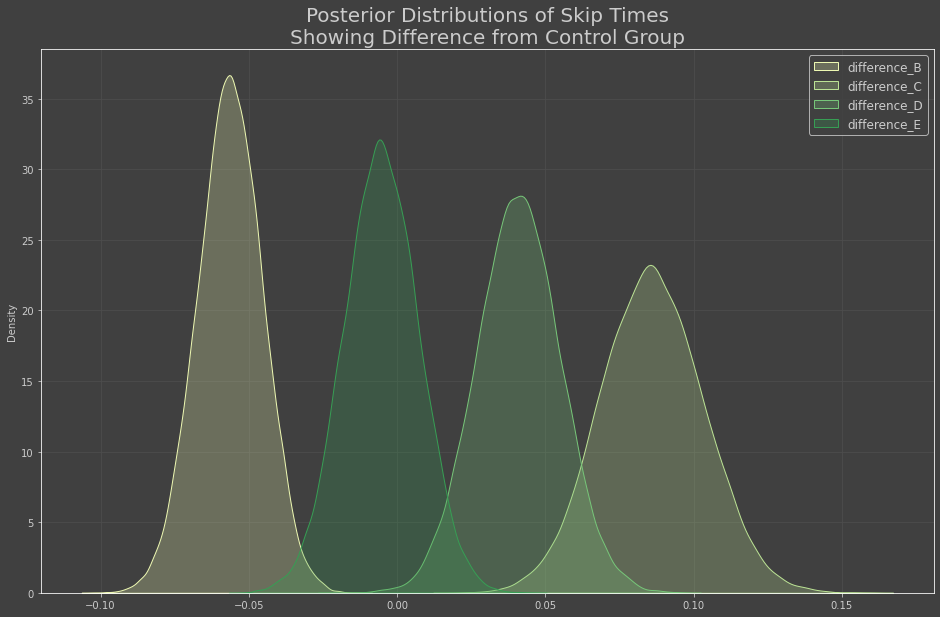

In [15]:
plt.figure(figsize=(16,10))

posteriors = []
differecne_vars = ['difference_B', 'difference_C', 'difference_D', 'difference_E']

for p in differecne_vars:
    posteriors.append(trace.get_values(p, burn=100))

for posterior in posteriors:
    sns.kdeplot(posterior, shade=True, palette=colors, legend = True)
    
plt.legend(loc="upper right", labels = differecne_vars, fontsize=12)
plt.title("Posterior Distributions of Skip Times\nShowing Difference from Control Group", fontsize=20)
plt.grid(color='#4d4d4d')

In [16]:

# alpha, beta, mean, variance, and std of control group

mean_of_A = full_df[full_df['test_group']=='A']['skipped'].mean()
std_of_A = full_df[full_df['test_group']=='A']['skipped'].std()
var_of_A = full_df[full_df['test_group']=='A']['skipped'].var()

kappa_of_A = ((mean_of_A * (1 - mean_of_A)) / var_of_A ) - 1
alpha_of_A = mean_of_A * kappa_of_A
beta_of_A = (1 - mean_of_A) * kappa_of_A

print("STATISTICS FOR CONTROL GROUP A\n")
print(f"Mean:   {round(mean_of_A, 4)}")
print(f"Std:    {round(std_of_A, 4)}")
print(f"Var:    {round(var_of_A, 4)}")
print(f"Alpha:  {round(alpha_of_A, 4)}")
print(f"Beta:   {round(beta_of_A, 4)}")
print(f"Kappa:   {round(kappa_of_A, 4)}")

STATISTICS FOR CONTROL GROUP A

Mean:   0.552
Std:    0.4975
Var:    0.2475
Alpha:  -0.0006
Beta:   -0.0004
Kappa:   -0.001


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_E, p_D, p_C, p_B, p_A, ab]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 51 seconds.


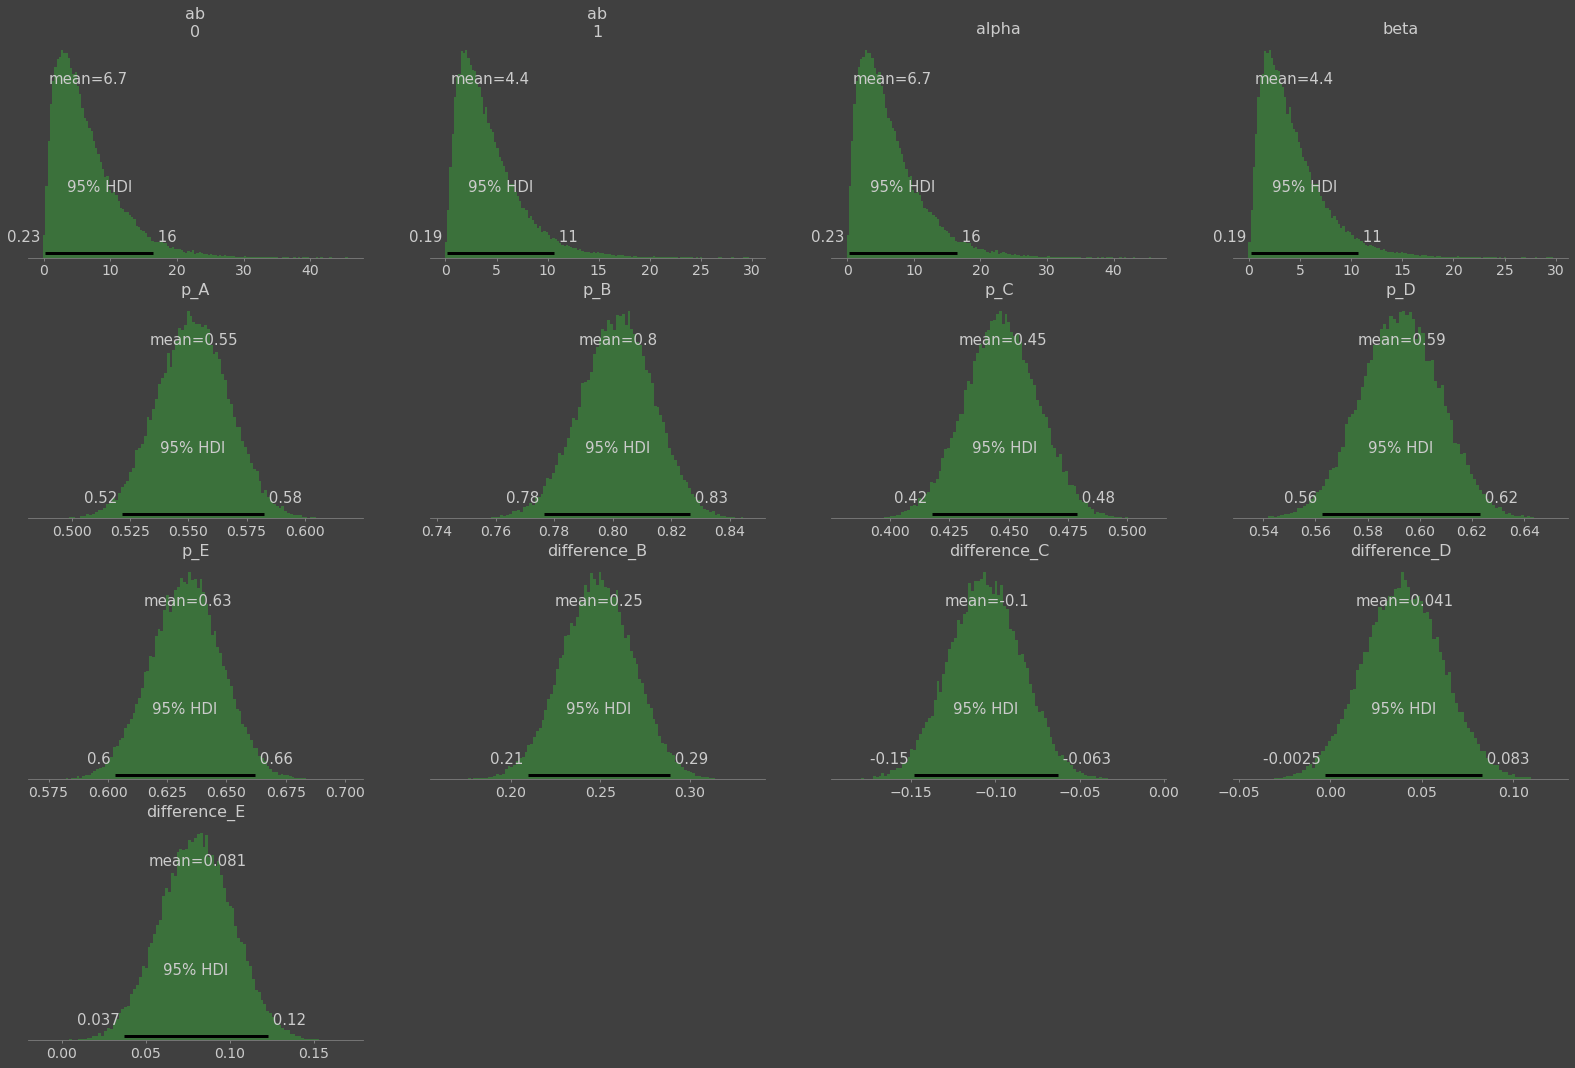

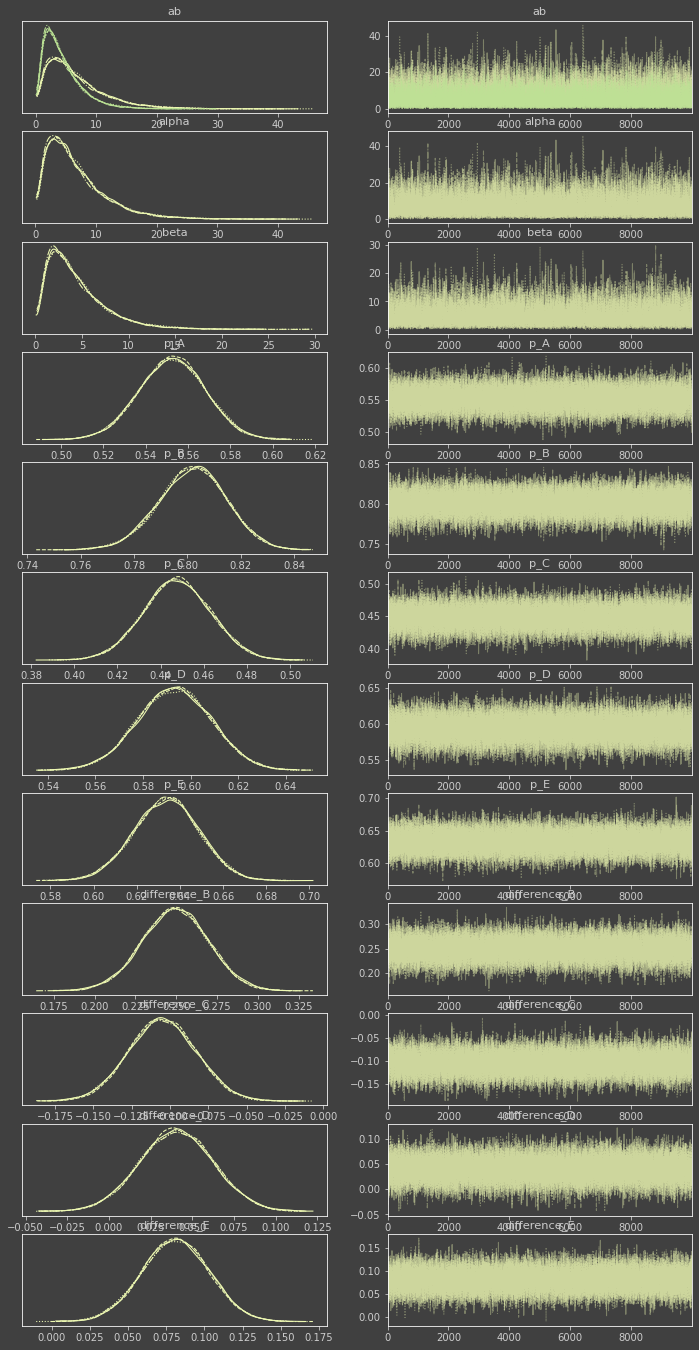

In [17]:


with pymc3.Model() as model:

    def logp_ab(value):
        return tt.log(tt.pow(tt.sum(value), -5/2))
    
    # uninformative prior for alpha and beta
    ab = pymc3.HalfFlat('ab', shape=2, testval=np.asarray([1., 1.]))
    pymc3.Potential('p(a, b)', logp_ab(ab))
    
    # our alpha and beta. Remove this code if you don't want to track alpha and beta
    alpha = pymc3.Deterministic('alpha', ab[0])
    beta = pymc3.Deterministic('beta', ab[1])
    
    # define priors
    p_A = pymc3.Beta('p_A', alpha=alpha, beta=beta)
    p_B = pymc3.Beta('p_B', alpha=alpha, beta=beta)
    p_C = pymc3.Beta('p_C', alpha=alpha, beta=beta)
    p_D = pymc3.Beta('p_D', alpha=alpha, beta=beta)
    p_E = pymc3.Beta('p_E', alpha=alpha, beta=beta)
    
    # define likelihood
    obs_A = pymc3.Binomial('obs_A', n=len(full_df[full_df['test_group'] == 'A']), p=p_A, observed=full_df[full_df['test_group'] == 'A']['skipped'].sum())
    obs_B = pymc3.Binomial('obs_B', n=len(full_df[full_df['test_group'] == 'B']), p=p_B, observed=full_df[full_df['test_group'] == 'B']['skipped'].sum())
    obs_C = pymc3.Binomial('obs_C', n=len(full_df[full_df['test_group'] == 'C']), p=p_C, observed=full_df[full_df['test_group'] == 'C']['skipped'].sum())
    obs_D = pymc3.Binomial('obs_D', n=len(full_df[full_df['test_group'] == 'D']), p=p_D, observed=full_df[full_df['test_group'] == 'D']['skipped'].sum())
    obs_E = pymc3.Binomial('obs_E', n=len(full_df[full_df['test_group'] == 'E']), p=p_E, observed=full_df[full_df['test_group'] == 'E']['skipped'].sum())
    
    # define metrics
    pymc3.Deterministic('difference_B', p_B - p_A)
    pymc3.Deterministic('difference_C', p_C - p_A)
    pymc3.Deterministic('difference_D', p_D - p_A)
    pymc3.Deterministic('difference_E', p_E - p_A)
    
    # sample distributions
    trace = pymc3.sample(draws=10000, start = pymc3.find_MAP(), step=pymc3.NUTS(target_accept=0.95), progressbar=True, return_inferencedata=False)
    
    az.plot_posterior(trace, kind="hist", hdi_prob = 0.95, color = 'limegreen')
    az.plot_trace(trace)
    

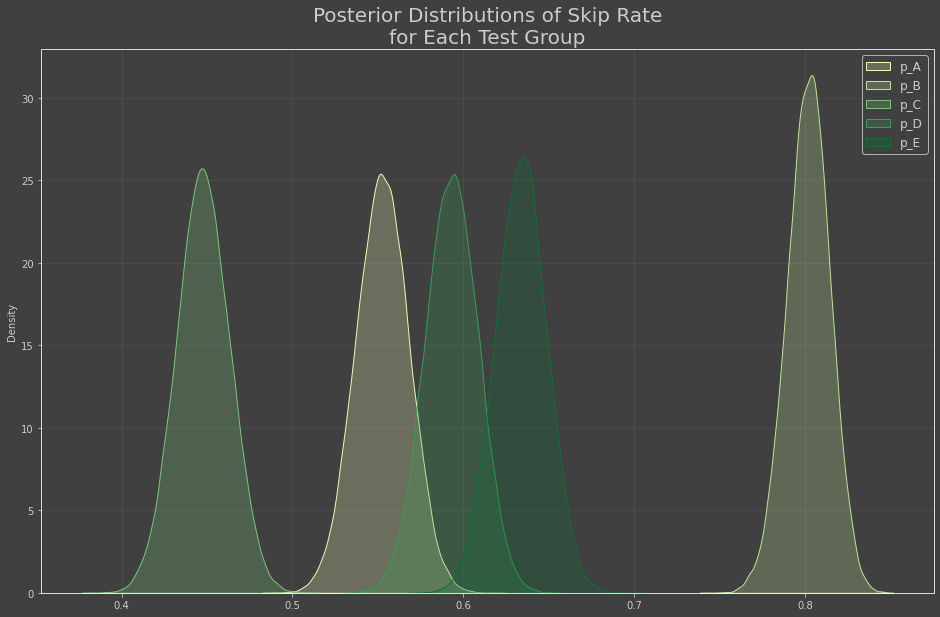

In [18]:
plt.figure(figsize=(16,10))

posteriors = []
posterior_vars = ['p_A', 'p_B', 'p_C', 'p_D', 'p_E']

for p in posterior_vars:
    posteriors.append(trace.get_values(p, burn=100))

for posterior in posteriors:
    sns.kdeplot(posterior ,shade=True, palette=colors, legend = True)
    
plt.legend(loc="upper right", labels = posterior_vars, fontsize=12)
plt.title("Posterior Distributions of Skip Rate\nfor Each Test Group", fontsize=20)
plt.grid(color='#4d4d4d')

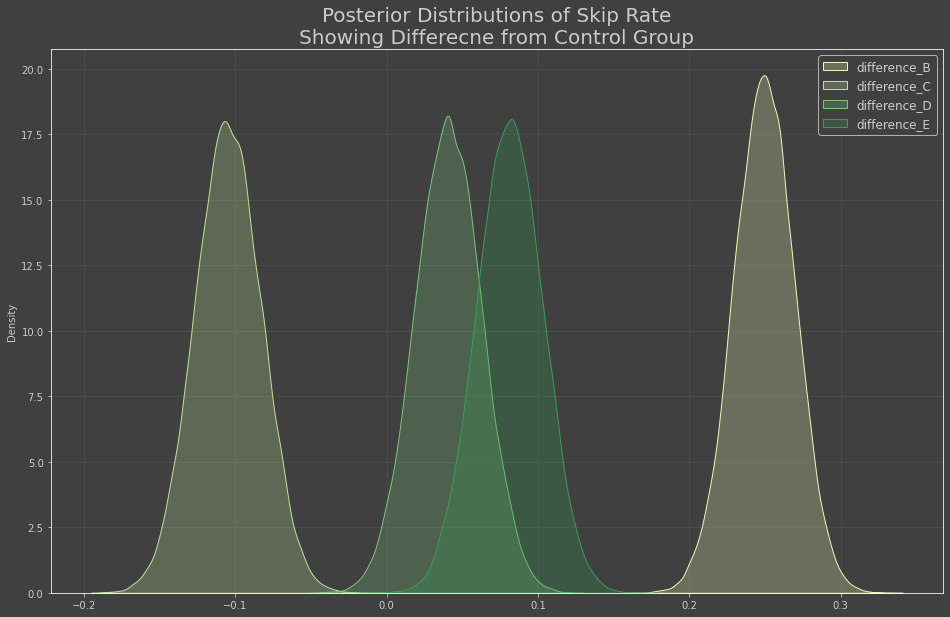

In [19]:
plt.figure(figsize=(16,10))

posteriors = []
differecne_vars = ['difference_B', 'difference_C', 'difference_D', 'difference_E']

for p in differecne_vars:
    posteriors.append(trace.get_values(p, burn=100))

for posterior in posteriors:
    sns.kdeplot(posterior, shade=True, palette=colors, legend = True)
    
plt.legend(loc="upper right", labels = differecne_vars, fontsize=12)
plt.title("Posterior Distributions of Skip Rate\nShowing Differecne from Control Group", fontsize=20)
plt.grid(color='#4d4d4d')

In [ ]:

plt.figure(figsize=(16,8))

cmap = sns.color_palette("YlGn", 9)

g = sns.barplot(x = weekday_total.weekday , y = weekday_total['date'].values , data = weekday_total, orient = 'v', palette=cmap, edgecolor=cmap)

plt.xticks(np.arange(0, 7, 1), size=15)
plt.yticks(size=15)
plt.ylabel('')
plt.title('Total Number of "Data Science" Podcasts per Weekday',fontsize=30)
plt.xlabel('')
plt.grid(color='#4d4d4d')
sns.despine(bottom=True, left=True)

for index, row in weekday_total['date'].iteritems():
    g.text(index  , row + 30, row, color='#cccccc', ha="center", fontsize=15)

plt.show()